Group XX (Name 1, Name 2, Name 3, Name 4)

# Homework 8

This homework revolves all around iterative schemes for solving linear systems. Let's start with the initializations, as usual.

In [1]:
import numpy as np                # basic arrays, vectors, matrices
import scipy as sp                # matrix linear algebra 
import scipy.sparse               # sparse matrix functions and classes
import scipy.sparse.linalg        # sparse matrix iterative solvers

import scipy.io                   # sparse matrix I/O

import matplotlib.pyplot as plt      # plotting
from matplotlib import animation, rc # animations

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

from IPython.core.display import HTML
HTML("""<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; }</style>""")

<div class="alert alert-info">
    
## Sparse Matrices and Fill-In
</div>

We have already seen that for large sparse matrices, the typical matrix factorizations such as the LU factorization or the Cholesky factorization can be prohibitively expensive. This is due to the phenomenon called **fill-in**, which refers to the fact that the factors can have many more non-zero entries than the matrix itself.

Let's consider an example. In the following, we load a reasonably large matrix from an external file (in the [*MatrixMarket* format](https://math.nist.gov/MatrixMarket/formats.html)), print out the number of non-zero entries, and visualize it. 

<div class="alert alert-danger">
    
**Note:** Please download the file `s3rmt3m3.mtx.gz` from the OLAT materials folder, and put it in the same directory as this notebook.
</div>

A has 207695 (0.72%) non-zero entries.


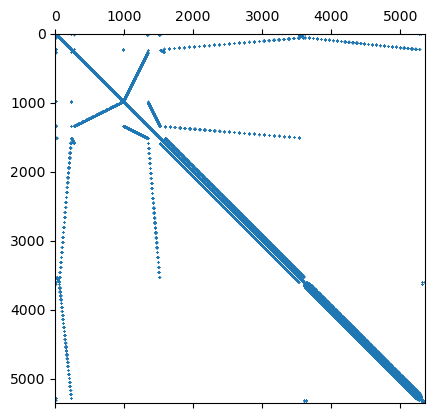

In [2]:
A = sp.io.mmread('s3rmt3m3.mtx.gz')

print( "A has %d (%.2f%%) non-zero entries." % (A.nnz, 100.0 * A.nnz / np.prod(A.shape)) )
plt.spy( A, markersize=.1 );

Note that $A$ is not represented as an ordinary NumPy array, but rather as a custom class:

In [3]:
A.__class__

scipy.sparse._coo.coo_matrix

The class `coo_matrix` stores a sparse matrix in [COOrdinate format](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)), and provides a similar set of functionality as NumPy arrays, while only the non-zero entries of $A$ are stored.

Let's investigate fill-in using the Cholesky factorization as an example. Remember, given $A$, the Cholesky factorization seeks a lower tridiagonal matrix $L$ such that
$$A = LL^T$$
holds.

The fill-in factor can then be computed as $f = \mathrm{nnz}(L)\ /\ \mathrm{nnz}(A)$.

Unfortunately, we cannot directly apply [`scipy.linalg.cholesky`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.cholesky.html) directly to a `coo_matrix` instance. However, we can convert the sparse representation to a full (also called dense) representation using the [`todense`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.coo_matrix.todense.html) method.



<div class="alert alert-success">

**Task:** Perform Cholesky decomposition on $A$ to obtain $L$. Visualize $L$, and compute and print the fill-in factor.

Notes:
- Unfortunately, it is not possible to directly apply [`scipy.linalg.cholesky`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.cholesky.html) to a `coo_matrix` instance. However, you can convert the sparse representation to a full (also called dense) representation using the [`todense`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.coo_matrix.todense.html) method.

- `coo_matrix` has an attribute `nnz`, but for the dense representation, use [`numpy.count_nonzero`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.count_nonzero.html).
</div>

In [4]:
# TODO: perform Cholesky decomposition, visualize L, print fill-in factor

As apparent, the number of matrix entries (and thus storage overhead) increases by a factor of 10.

The same problem can occur when taking powers of $A$, or computing $A^T A$ (e.g. for least-squares problems).

<div class="alert alert-info">

## Jacobi Method
</div>

The Jacobi method is a simple iterative scheme for solving linear systems of equations. Let's first set up a small test problem:

In [5]:
def sdd_system( m ):

    n = int(np.sqrt(m))
    
    # generate random RHS
    b = 2.0 * np.random.rand(m) - 1.0

    A = sp.sparse.diags( [4.01, -1, -1, -1, -1], [0, 1, -1,n, -n], shape=(m, m) ).toarray()
    return A, b
    
A, b = sdd_system( 5 )

print(np.linalg.cond(A))

5.237486810921735


The Jacobi iteration is guaranteed to converge for strictly diagonally dominant $A$.

<div class="alert alert-success">

**Task**: Write a function `is_sdd` that checks whether $A$ is strictly diagonally dominant, and verify that this is true for the test problem.

</div>

In [6]:
def is_sdd( A ):
    # TODO
    D = np.diag(np.abs(A)) # Find diagonal coefficients
    S = np.sum(np.abs(A), axis=1) - D # Find row sum without diagonal
    if np.all(D > S):
        print ("True")
    else:
        print ("False")
    
    return True
    
assert is_sdd(A)

True


<div class="alert alert-success">
    
**Task:** Implement the function `jacobi_iter` below to perform Jacobi iterations. Validate on the test problem that the residual is small after 100 iterations.

</div>

In [7]:
def jacobi_iter( A, b, n=100 ):
    x = np.zeros(len(A))
    # TODO
    D = np.diag(A)
    R = A - np.diagflat(D)
    
    for i in range(n):
        x = (b - np.dot(R,x))/ D
        #print(x)
        return x

x = jacobi_iter(A, b)
print( np.linalg.norm(b-A@x) )

0.3513373255931373


<div class="alert alert-success">

**Task:** 
- Write a function `jacobi_iter_hist` that returns a list of all iterates, not just the final iterate. 
- Use this to create a convergence plot by plotting the residuals as a function of the iteration number.

Note: [`pyplot.yscale`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.yscale.html) allows setting logarithmic scaling on the $y$-axis.

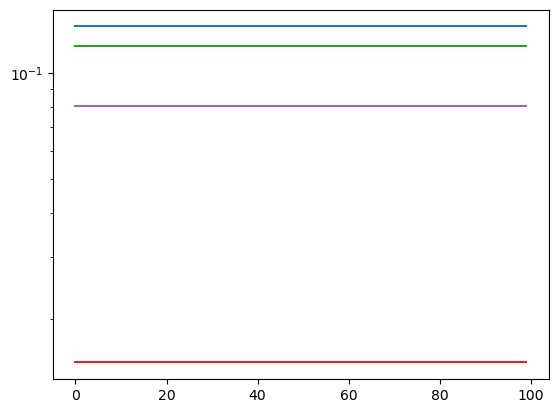

In [8]:
def jacobi_iter_hist( A, b, n=100 ):
    
    # TODO 
    X = []
    z= np.zeros(len(A))
    D = np.diag(A)
    R = A - np.diagflat(D)
    
    for i in range(n):
        z = (b - np.dot(R,x))/ D
        X.append(z)
    
        
    return X

X = jacobi_iter_hist(A, b)
# TODO: plot iteration history
plt.plot(X);
plt.yscale('log')

<div class="alert alert-success">

**Task:** Plot the convergence (as above) for problem sizes 5, 10, 20, 50, 100, in a single plot.


Note: Use a legend (cf. [pyplot.legend](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html)) so that it is clear which curve belongs to which problem size.

ValueError: shapes (10,10) and (5,) not aligned: 10 (dim 1) != 5 (dim 0)

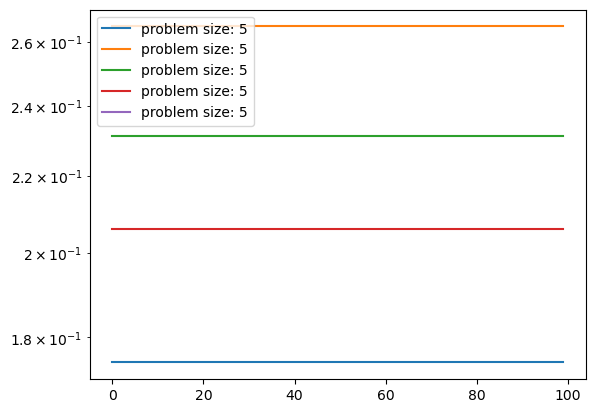

In [9]:
for dim in [5, 10, 20, 50]:
    A, b = sdd_system(dim)

    # TODO
    X = jacobi_iter_hist(A, b)
    
    plt.plot(X, label = f"problem size: {dim}");
    plt.legend(loc="upper left")
    plt.yscale('log')

<div class="alert alert-info">

## SOR Method
</div>

The **Successive Overrelaxation (SOR) Method** aims at solving linear systems in an iterative manner. 
The SOR method is a variant of the Gauss–Seidel method, resulting in faster convergence. In the following, the SOR method is briefly introduced.
As usual, we consider the linear system $A \mathbf{x} = \mathbf{b}$.

The SOR method first performs the Gauss-Seidel update:
\begin{equation*}
\mathbf{x}^{(k+1)}_{GS}  = -(D+L)^{-1}U\mathbf{x}^{(k)} + (D+L)^{-1} \mathbf{b},
\end{equation*}
then it uses a combination of both $\mathbf{x}^{(k+1)}_{GS}$ and $\mathbf{x}^{(k)}$ for the final update: 
\begin{equation*}
\mathbf{x}^{(k+1)}  = (1-\omega) \mathbf{x}^{(k)} + \omega \mathbf{x}^{(k+1)}_{GS}.
\end{equation*}
The choice $\omega < 1$ is called under-relaxation, while $\omega > 1$ is called over-relaxation. 

In this exercise, we are going to try the SOR method on the so-called Poisson equation

$$
-\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) = f \qquad u|_{\partial\Omega} = 0 \qquad \Omega = [0,1]^2
$$

which is a partial differential equation (PDE). (Don't worry, we will not look into this further at this time, but use this to generate an interesting large and sparse linear system.)

Just to give you a tiny bit of a physical interpretation: the Poisson equation can be used to model the temperature distribution ($\mathbf{u}$) on a thin square (made from some arbitrary material). The square is heated in certain places (described by the source term $f$), but kept at the temperature $0$ along its edges.

By discretizing the square as an $n\times n$ grid of points, we can turn the PDE into a linear system

$$
A\mathbf{u} = \mathbf{f},
$$

whose solution will give the temperature distribution on the square.

The function `possion_system` below generates such systems for us. As we have $n\times n$ grid points (i.e., variables in the system), $A$ is an $n^2\times n^2$-matrix, and is thus large even for moderately sized $n$. However, only very few of its entries are non-zero.

(2500, 2500) 12300 0.1968%


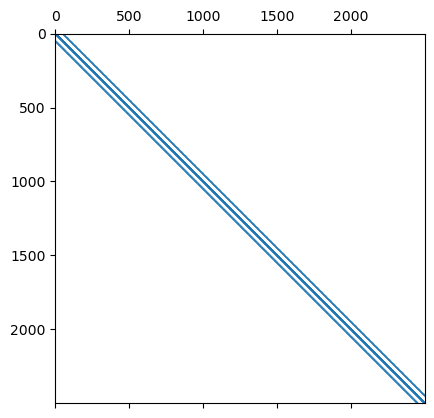

In [10]:
def poisson_system(n):
    
    d0 = np.ones(n*n)
    d1 = np.ones(n*n); d1[n-1::n] = 0

    A = scipy.sparse.diags([4*d0, -d1, -d1, -d0, -d0], [0, -1, 1, -n, n], 
                           shape=(n*n,n*n), format='coo', dtype="int8" )

    t = np.linspace(-5, 5, n)
    b = np.where(np.linalg.norm(np.array(np.meshgrid(t,t)), axis=0) < 1, 1.0, 0.0).ravel()
    
    return A, b


n = 50
A, f = poisson_system(n)
print( A.shape, A.nnz, "%.4f%%" % (100.0*(A.nnz/(n**4))) )
plt.spy( A, ms=.1 );

The right-hand side $\mathbf{f}$ represents the heating. While it is an $(n\cdot n)$-vector, we can reinterpret it as an $n\times n$-matrix and visualize it.

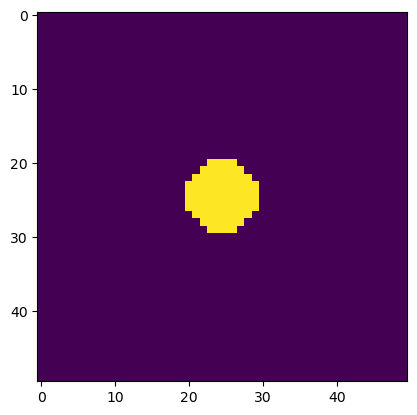

In [11]:
plt.imshow(f.reshape(n, n));

So heating is applied in a circle in the middle of the square.

<div class="alert alert-success">

**Task:** Implement the function `solve_Poisson_equation` below to solve the heat equation using the SOR method. Other than the coefficient matrix $A$ and the right hand side vector $\mathbf{f}$, the function also takes a scalar input `tol`. This parameter is used as a stopping criteria such that when the norm of the residual is below `tol`, the function terminates. Try different values of the relaxation parameter $\omega$ to improve the convergence behavior. 

Note: Take advantage of the sparsity while implementing the function. Avoid accessing single elements of the matrix.

In [ ]:
def solve_Poisson_equation(A,f,tol):
    
    # TO DO
    
    B = A.toarray()
    D = np.diag(np.diag(B))
    L = np.tril(B) - D
    U = np.triu(B) - D
    
    
    
    return solution

u = solve_Poisson_equation(A,f,0.0001)


Let's now print the residual and visualize the solution.

In [ ]:
print( "residual =", np.linalg.norm(A@u - f) )
plt.imshow(u.reshape(n,n));

While the residual may not be numerically small, this kind of accuracy is often good enough for this kind of applications.